### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [172]:
#!pip install numdifftools

In [173]:
import numdifftools as nd
#H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
#sigma_laplace = np.linalg.inv(H)**0.5

### Solution

In [174]:
import numpy as np
import math as math
import scipy.stats as stats
from scipy import optimize
from matplotlib import pyplot as plt

data = np.load('hw3_data_1.npy')
data_value = data[:, 0]
data_unc = data[:, 1]
data_size = len(data)

In [175]:
#1

mean_data = np.sum(data_value / (data_unc ** 2)) / np.sum(1 / (data_unc ** 2))
mean_unc = 1 / math.sqrt(np.sum(1 / (data_unc ** 2)))

print("Mean of the data:", mean_data)
print("Standard Error of the Mean:", mean_unc)


Mean of the data: 3.9179920346060557
Standard Error of the Mean: 0.09481084100510956


In [176]:
# 2

def Likelihood_ln(mu, x, unc):
    Billy = np.sum( 0.5 * ( ( ( x - mu ) / unc ) ** 2 ) - np.log( 1 / ( unc * np.sqrt( 2 * np.pi ) ) ) )
    return Billy

f_squared = lambda beta: Likelihood_ln(beta[0], data_value, data_unc)
guess_mean = 4
guess_unc = 0.1
beta0 = (guess_mean, guess_unc)

optimize_f = optimize.fmin(f_squared, beta0)
print("Mean of the data:", optimize_f[0])
print("Standard Error of the Mean:", optimize_f[1])

Optimization terminated successfully.
         Current function value: 147.257863
         Iterations: 44
         Function evaluations: 89
Mean of the data: 3.9179920211434376
Standard Error of the Mean: 0.09915009973570704


In [177]:
#3

temp_grid = np.linspace(np.min(data), np.max(data), 1000)
temp_dist = stats.norm.pdf(temp_grid, loc = mean_data, scale = mean_unc)

sigma_mu = np.diff(np.log(temp_dist), n = 2)
sigma_mu /= (temp_grid[1] - temp_grid[0]) ** 2
sigma_mu *= -1
sigma_mu = 1 / np.sqrt(sigma_mu)[0]

print("Fisher Uncertinty Estimated on the Mean:", sigma_mu)

Fisher Uncertinty Estimated on the Mean: 0.09481084100285782


In [178]:
#4

sample_number = 1000

def Bootstrap(values, N):
    spot = np.random.randint(0, data_size, size = (N, data_size))
    samples = values[spot]
    return samples

Bootstrapy = Bootstrap(data, sample_number)

Optimization terminated successfully.
         Current function value: 146.344328
         Iterations: 49
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: 148.522279
         Iterations: 49
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 152.030988
         Iterations: 47
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 148.590641
         Iterations: 42
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 145.484584
         Iterations: 46
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 148.334950
         Iterations: 44
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 136.861675
         Iterations: 50
         Function evaluations: 97
Optimization termin

Text(0, 0.5, 'count')

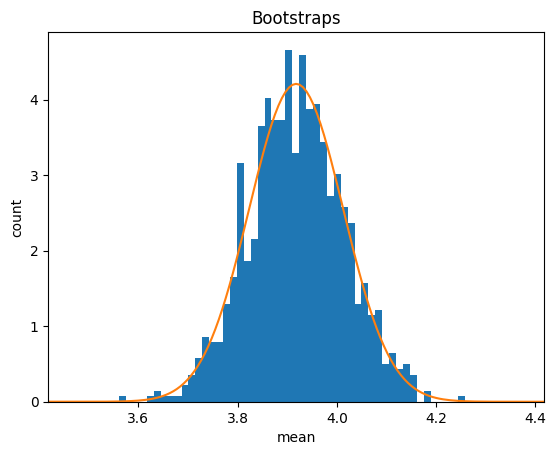

In [179]:
# 5

bootstrap_means = []
spread = 0.5

for ii in Bootstrapy:
    Jim = lambda beta: Likelihood_ln(beta[0], ii[:, 0], ii[:, 1])
    optimize_Jim = optimize.fmin(Jim, beta0)
    Jimmy = optimize_Jim[0]
    bootstrap_means.append(Jimmy)

temp_grid2 = np.linspace(np.min(data), np.max(data), 1000)
temp_dist2 = stats.norm.pdf(temp_grid2, loc = mean_data, scale = mean_unc)

plt.hist(bootstrap_means, bins = 50, density = True)
plt.plot(temp_grid2, temp_dist2)
plt.xlim(mean_data - spread, mean_data + spread)
plt.title("Bootstraps")
plt.xlabel("mean")
plt.ylabel("count")

In [198]:
# 6

def Likelihood_lap(mu, x, delta):
    Bobby = np.sum(np.abs(x - mu) / delta + np.log(2 * delta))
    return Bobby

Tim = lambda beta: Likelihood_lap(beta[0], data_value, data_unc)
optimize_Tim = optimize.fmin(Tim, beta0)

print("Mean of the data:", optimize_Tim[0])
print("Standard Error of the Mean:", optimize_Tim[1])

Optimization terminated successfully.
         Current function value: 157.201616
         Iterations: 69
         Function evaluations: 129
Mean of the data: 4.042947694529403
Standard Error of the Mean: 0.1045749649794237


In [212]:
#7

def AIC(k, likelihood):
    aic = 2 * (k - likelihood + ( (2 * k * (k + 1)) / (data_size - k - 1)))
    return aic

Gauss = AIC(1, optimize_f[0])
Laplace = AIC(2, optimize_Tim[0])

print(Gauss)
print(Laplace)

print("Gauss is Better")

-5.754351389225651
-3.8384727086464343
Gauss is Better
